# ***LETTER RECOGNITION DATASET***

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib



from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [14]:
# !pip install ucimlrepo

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
letter_recognition = fetch_ucirepo(id=59) 
  
# data (as pandas dataframes) 
X = letter_recognition.data.features 
y = letter_recognition.data.targets 
  
# metadata 
print(letter_recognition.metadata) 
  
# variable information 
print(letter_recognition.variables) 


{'uci_id': 59, 'name': 'Letter Recognition', 'repository_url': 'https://archive.ics.uci.edu/dataset/59/letter+recognition', 'data_url': 'https://archive.ics.uci.edu/static/public/59/data.csv', 'abstract': 'Database of character image features; try to identify the letter', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 20000, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': [], 'target_col': ['lettr'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1991, 'last_updated': 'Thu Sep 28 2023', 'dataset_doi': '10.24432/C5ZP40', 'creators': ['David Slate'], 'intro_paper': None, 'additional_info': {'summary': 'The objective is to identify each of a large number of black-and-white rectangular pixel displays as one of the 26 capital letters in the English alphabet.  The character images were based on 20 different fonts and each letter within these 20 fonts wa

In [15]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 0. Understand our data

1. Vị trí và kích thước (Bounding box):
    - 'x-box', 'y-box': vị trí góc dưới bên trái của khung bao quanh chữ
    - 'width', 'height': chiều rộng và chiều cao của khung bao quanh chữ
    - e.g: chữ *'I'* sẽ có width nhỏ, chữ *'M'* sẽ có width lớn
2. Mật độ điểm ảnh (Pixel Density):
    - `onpix`: tổng số pixel "on" (màu đen) bên trong khung hình chữ
    - e.g: chữ *'B'* sẽ tốn nhiều pixel hơn chữ *'L'*
3. Trọng tâm (Center of mass):
    - `x-bar`, `y-bar`: tọa độ trung bình của các pixel (trọng tâm của chữ cái)
    - e.g: chữ *'A'* có trọng tâm thấp hơn chữ *'V'*
4. Sự biến thiên và tương quan (Variance & Corelation):
    - Các chỉ số còn lại (`x2bar`, `y2bar`, `xybar`,...) đo lường chữ cái phân tán theo chiều dọc/ngang hay đường chéo, đối xứng,....
    

## 1. EDA

### 1.1 Data structure & Quality

####  Overview, Shape,...

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16000, 16), (4000, 16), (16000, 1), (4000, 1))

In [17]:
X_train.describe()    

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,4.024687,7.042125,5.121250,5.377063,3.506250,6.897625,7.494375,4.635063,5.180125,8.287437,6.449375,7.929437,3.045437,8.334500,3.690937,7.802500
std,1.911820,3.303583,2.016384,2.266237,2.190037,2.030739,2.325872,2.710967,2.391477,2.491426,2.626165,2.083112,2.332158,1.543295,2.566092,1.616913
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,4.000000,4.000000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.000000,7.000000,1.000000,8.000000,2.000000,7.000000
50%,4.000000,7.000000,5.000000,6.000000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.000000,8.000000,3.000000,8.000000,3.000000,8.000000
75%,5.000000,9.000000,6.000000,7.000000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.000000,9.000000,4.000000,9.000000,5.000000,8.000000
max,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000


In [18]:
X_train.head(10)

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
5894,4,7,5,5,4,6,7,3,7,11,8,9,3,8,4,8
3728,4,7,6,5,5,6,8,3,7,11,8,9,3,8,4,7
8958,3,5,4,3,3,7,8,5,5,7,7,6,5,9,2,6
7671,4,10,6,7,6,5,7,5,7,6,6,12,3,8,6,9
5999,4,10,6,8,4,8,11,2,3,4,10,9,3,11,1,8
5751,1,0,1,1,1,5,7,5,8,7,6,12,0,8,6,9
1688,4,8,6,6,4,7,7,3,9,5,6,8,3,8,7,8
6836,3,6,4,4,3,7,9,7,4,7,8,7,3,8,2,8
6536,3,8,5,6,6,8,7,4,3,6,6,7,7,8,7,6
4842,4,10,5,8,4,5,12,4,7,9,12,7,2,12,1,7


#### Check duplicated samples & missing values

In [19]:
X_train_dup_count = X_train.duplicated().sum()
print(f"Number of duplicated samples in X_train: {X_train_dup_count}")

# Show duplicated samples
# duplicated_samples = X_train[X_train.duplicated(keep=False)]
duplicated_samples = X_train[X_train.duplicated(keep='first')]
duplicated_samples

Number of duplicated samples in X_train: 948


,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
19987,3,7,3,5,1,0,1,6,6,0,0,6,0,8,0,8
15809,2,5,4,3,3,9,6,4,6,10,4,6,2,8,3,8
19630,1,0,2,1,0,2,1,6,4,0,2,5,0,8,0,8
9883,2,3,3,2,1,7,8,6,6,7,9,8,3,10,1,8
15865,1,0,1,0,0,8,7,6,4,7,6,8,2,8,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,2,6,4,4,2,11,3,3,2,10,1,9,2,6,2,8
1899,2,3,4,2,2,9,6,4,6,10,4,6,2,8,3,8
3005,1,1,2,1,0,7,14,1,4,7,10,8,0,8,0,8
189,2,2,1,4,1,7,7,1,7,7,6,8,0,8,3,8


- Comment: 
    + Duplication: **948 row duplicated** &rarr; remove it
    + Missing value: **no**

### 1.2 Univariate Analysis

#### Are classes balanced?

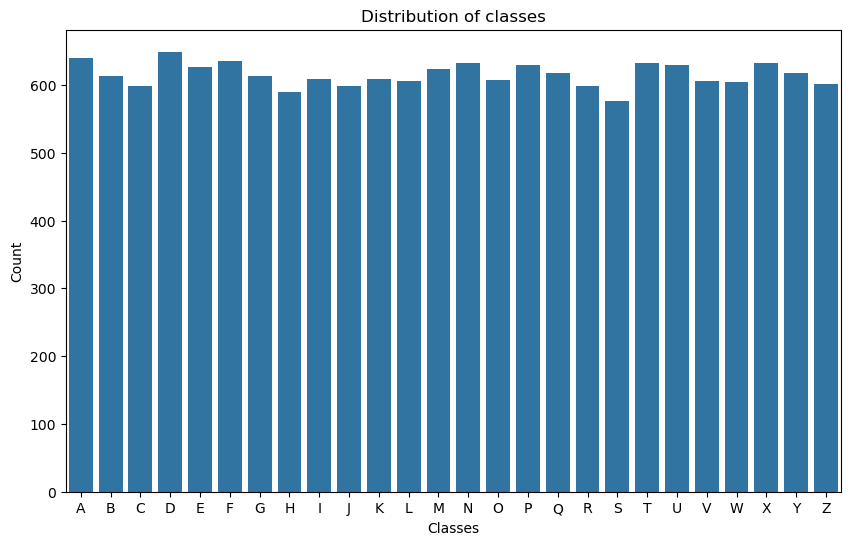

In [20]:
# Check balanced classes
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train.values.ravel(), order=sorted(y_train['lettr'].unique()))
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title("Distribution of classes")
plt.show();

- Comment: 
    + Oke, balance

#### Numeric: KDE plot to see skewness & boxplot -> outliers

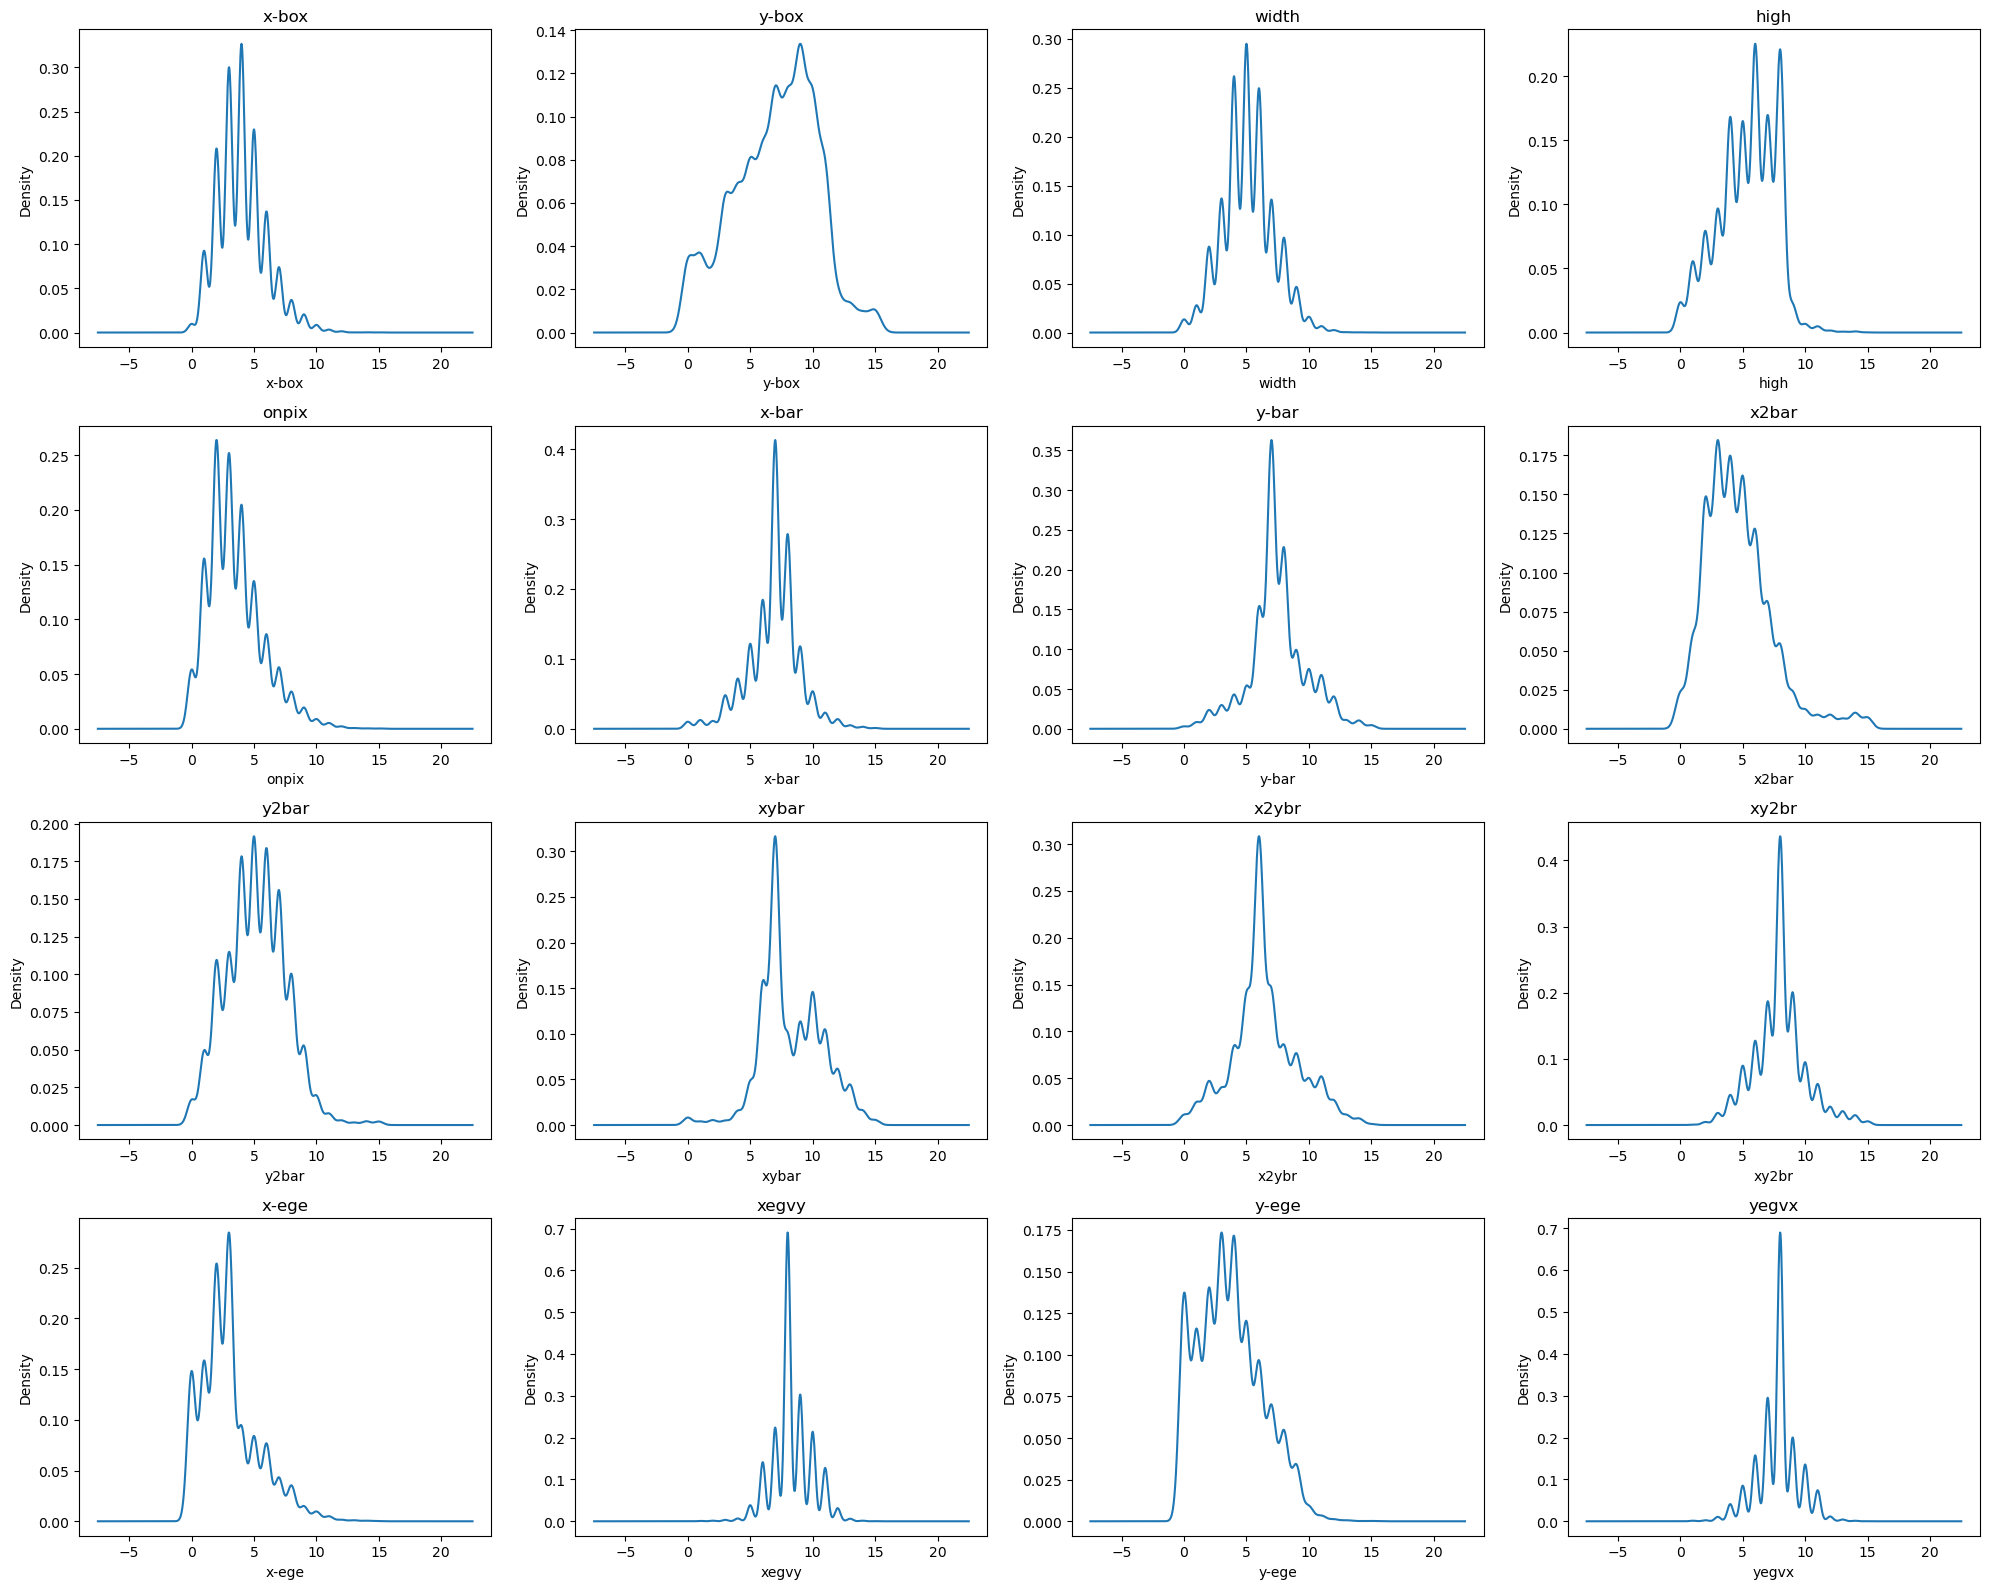

In [21]:
# KDE plot
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for idx, col in enumerate(X_train.columns):
    X_train[col].plot(kind='kde', ax=axes[idx], title=col)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Density')

plt.tight_layout()
plt.show()

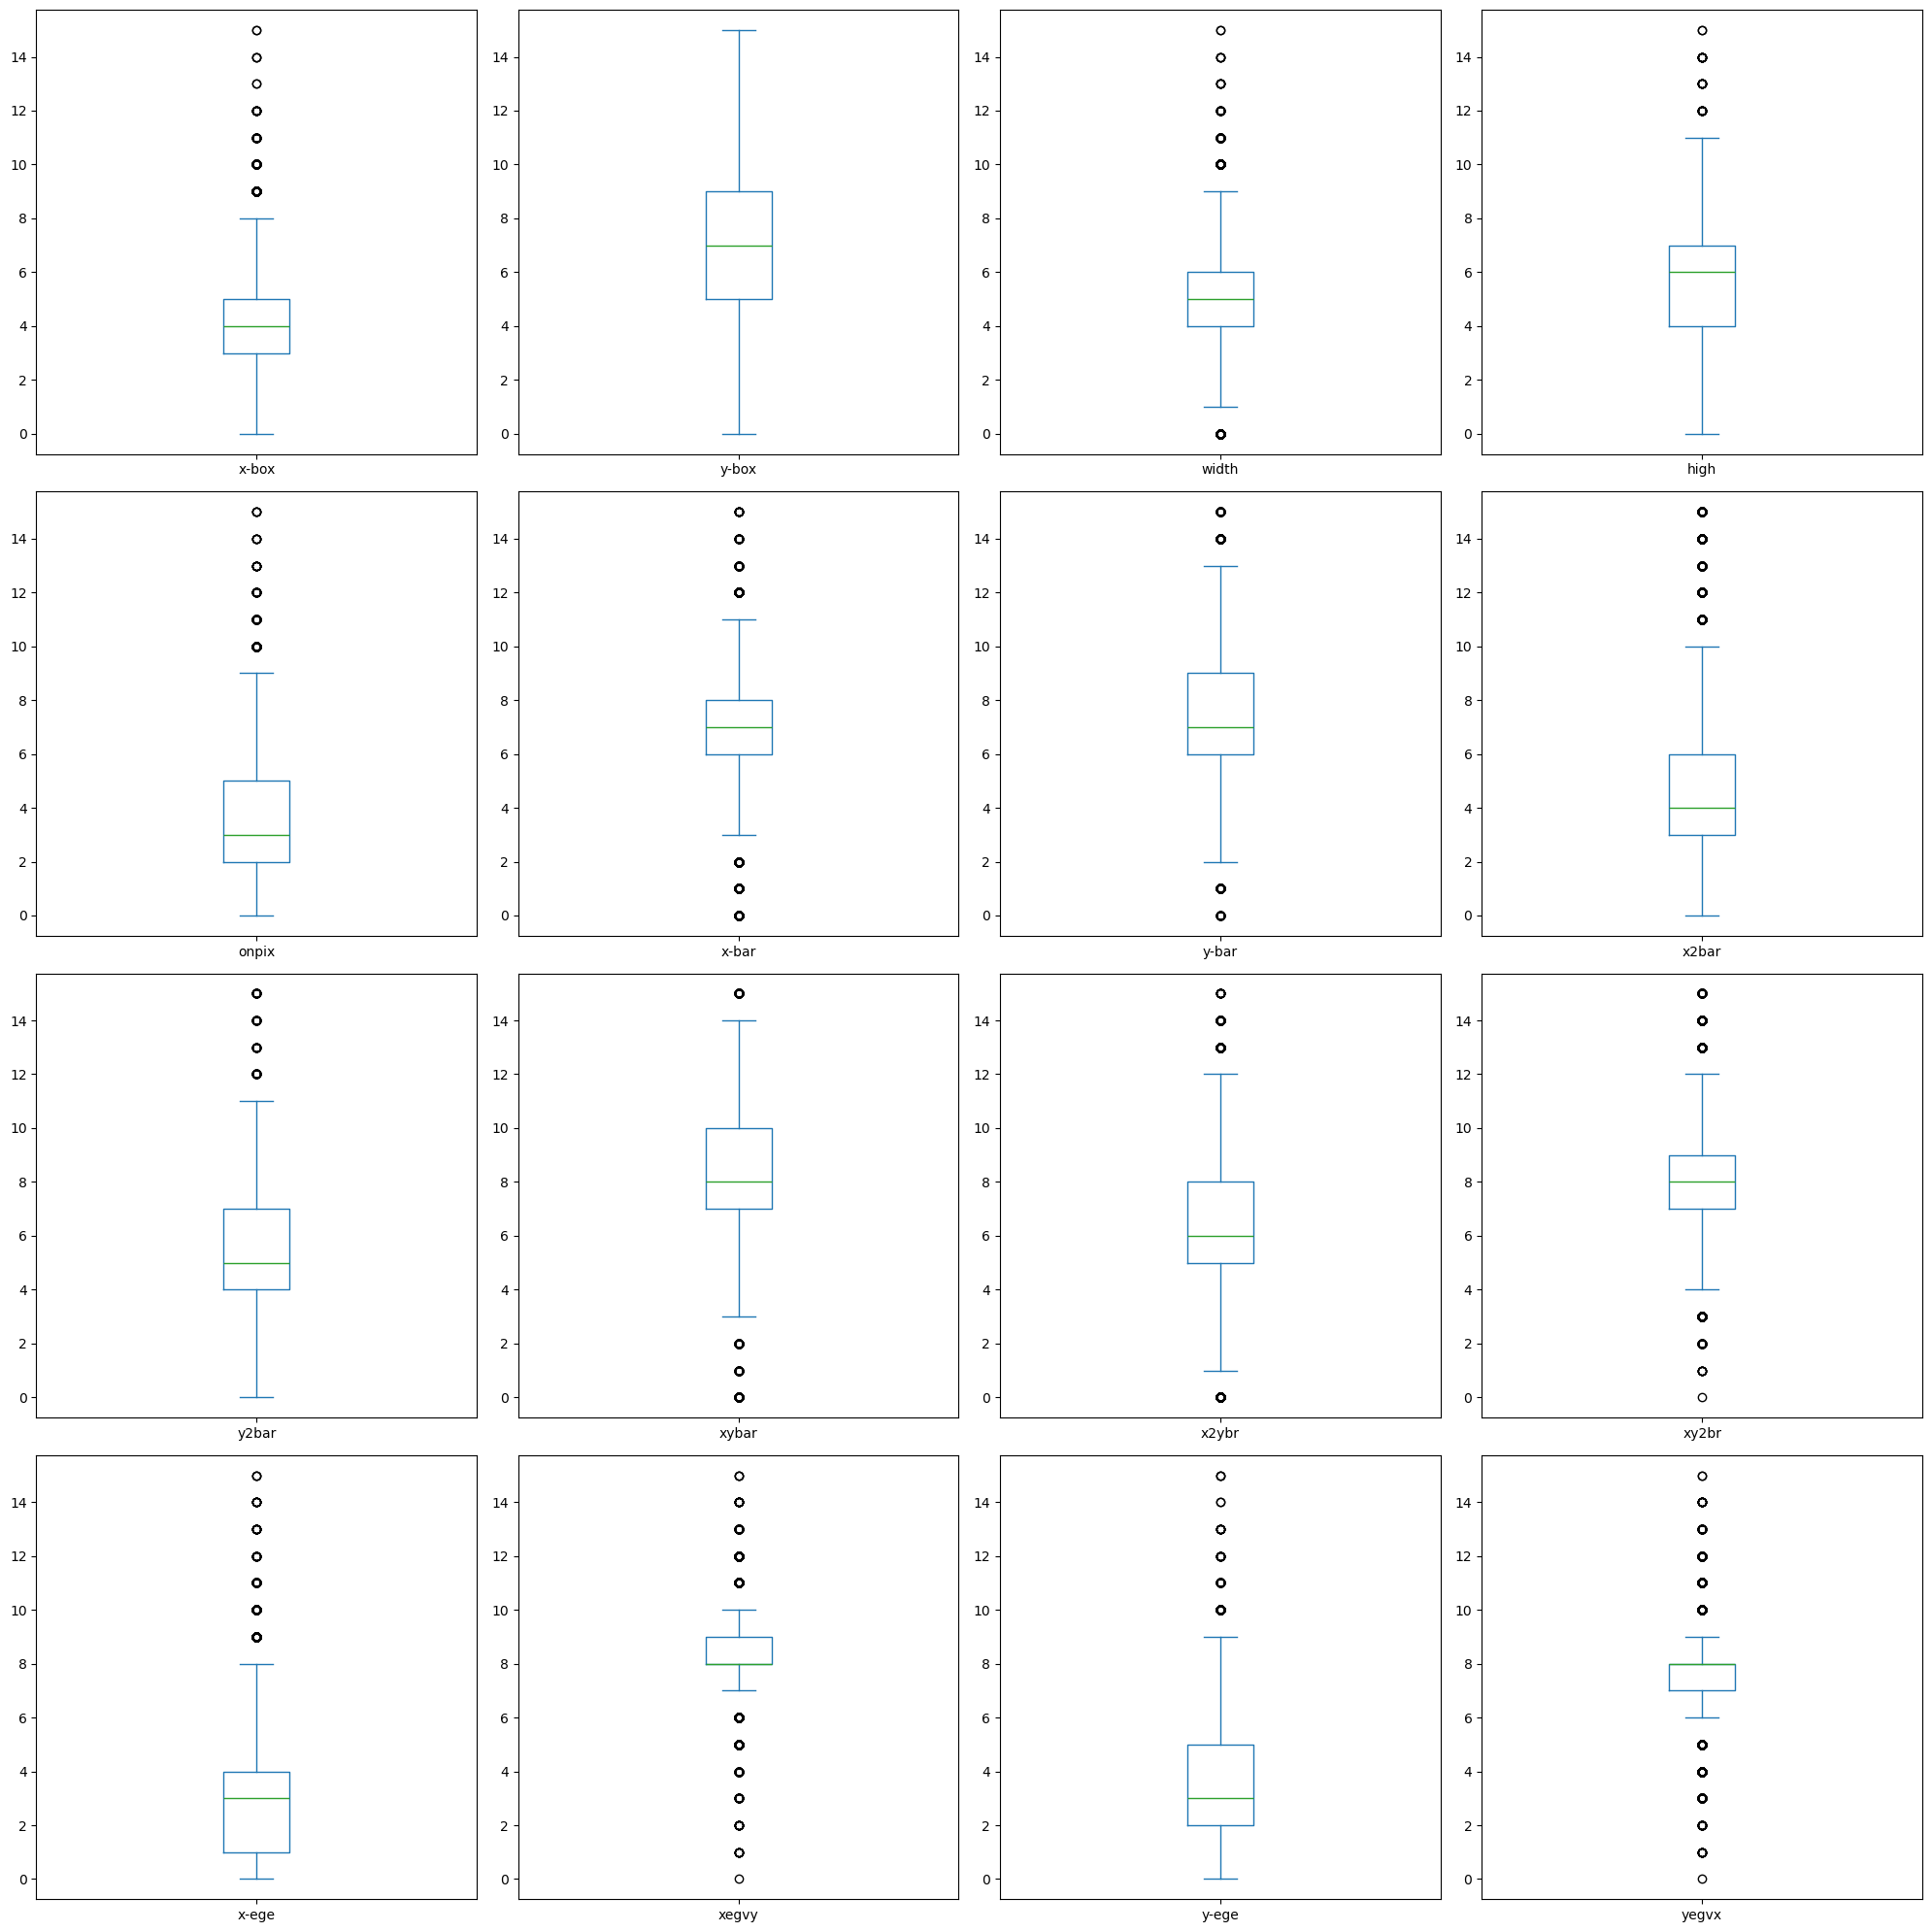

In [22]:
X_train.plot(figsize=(20, 20), kind='box', subplots=True, layout=(4, 4), sharex=False)
plt.tight_layout()
plt.show()

- Comment:
    - KDE: some features like **x2bar, y2bar, xybar** are right-skewed
    - Boxplot: some features have many outliers such as **x2bar, y2bar, xybar, xegvy, yegvx**


### 1.3 Bivariate Analysis (Phân tích 2 biến)

#### Boxplot feature vs target to see distribution of feature per class

In [23]:
# # Boxplot for each feature by class:
# BOXPLOT_N_COLUMNS = 4
# fig, axes = plt.subplots(ncols=BOXPLOT_N_COLUMNS, nrows=len(X_train)//BOXPLOT_N_COLUMNS + 1, figsize=(20, 5*len(X_train)//BOXPLOT_N_COLUMNS))

# # axes: many axis, because our figure have a lots subplot, so axes is 2D array.
# axes = axes.flatten()   # flatten 2D array -> 1D array

# for idx, col in enumerate(X_train.columns):
#     sns.boxplot(data=X_train.assign(Class=y_train), x='Class', y=col, ax=axes[idx])    # ax: current subplot which we are interacting in our figure
#     axes[idx].set_title(f"{col} by Class")
#     axes[idx].tick_params(axis='x', rotation=25)    # rotate x axis 25* counterclockwise (left rotation) (clockwise - right rotation)

# # Hide abundance subplot
# for idx in range(len(X_train.columns), len(axes)):
#     axes[idx].set_visible(False)

# plt.tight_layout()
# plt.show();


### 1.4 Multivariate analysis

#### Heatmap

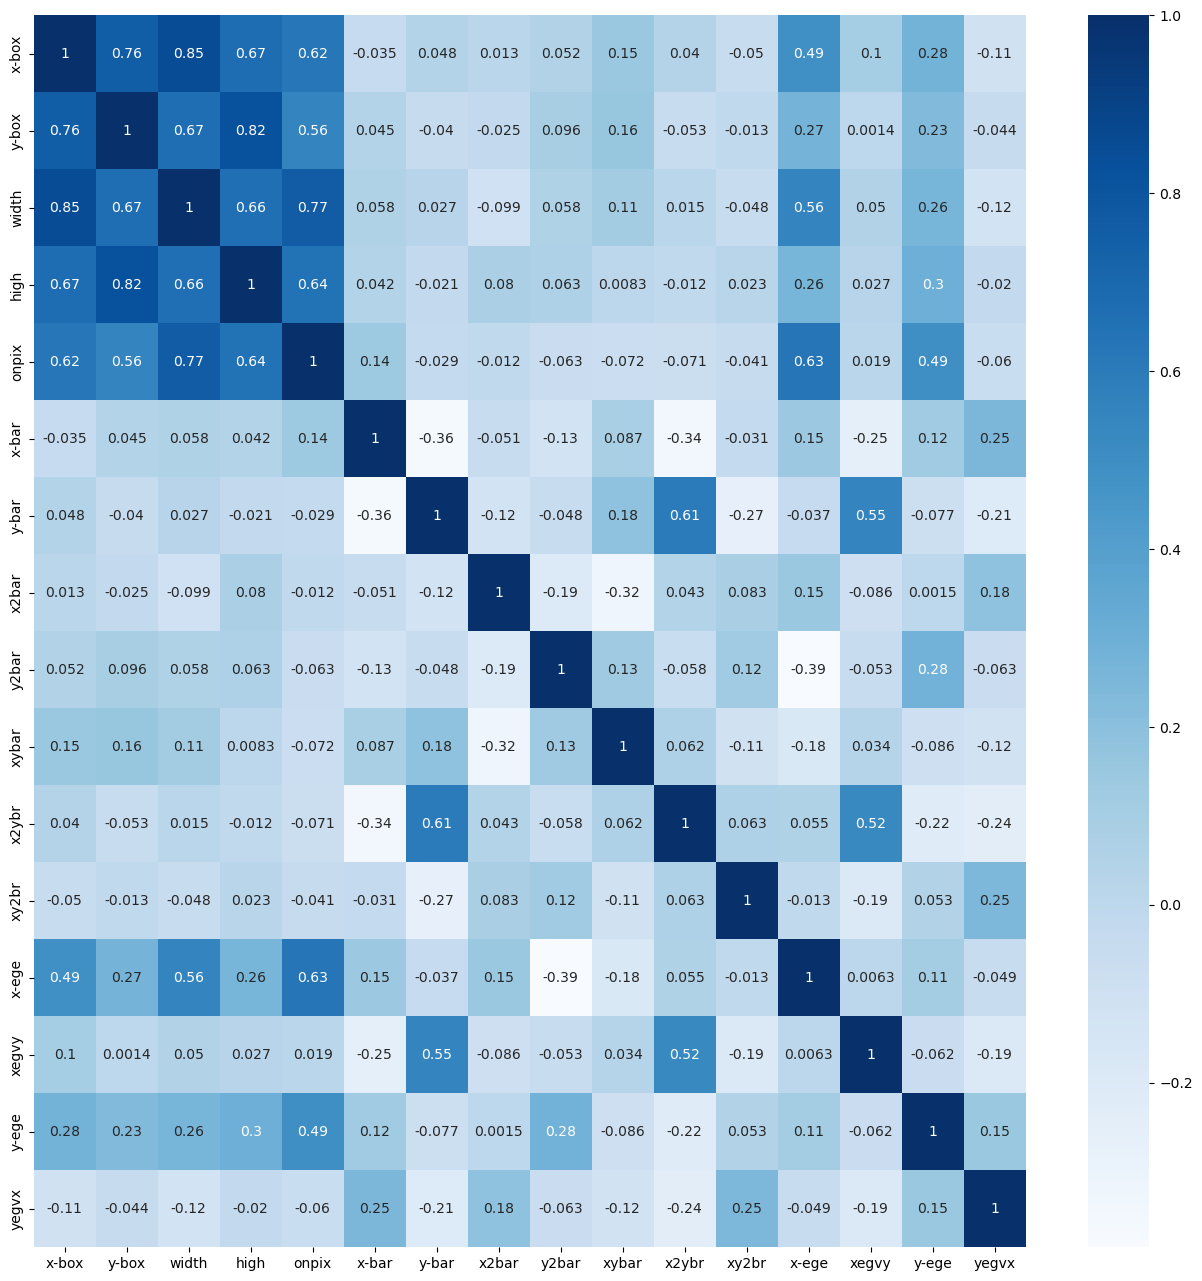

In [41]:
corr_matrix = X_train.corr(method='pearson', numeric_only=True)
# corr_matrix

plt.figure(figsize=(16, 16))
sns.heatmap(data=corr_matrix, annot=True, cmap='Blues')
plt.show();

#### Pairplot 

In [24]:
# sns.pairplot(X_train.assign(Class=y_train), hue='Class', diag_kind='kde', plot_kws={'alpha': 0.5}, palette='colorblind')
# plt.suptitle('Pairplot - Class Overlap Visualization', y=1.02)
# plt.tight_layout()
# plt.show();

## 2. Data preprocessing and Model building

- From EDA, we have to solve some issues:
    + Remove duplicated samples

In [25]:
# Remove duplicated samples from X_train
print(f"Shape before removing duplicates: {X_train.shape}")
X_train_clean = X_train.drop_duplicates()
# Remove corresponding y_train
y_train_clean = y_train.loc[X_train_clean.index]

print(f"Shape after removing duplicates: {X_train_clean.shape}")
print(f"Removed {X_train.shape[0] - X_train_clean.shape[0]} duplicated samples")

Shape before removing duplicates: (16000, 16)
Shape after removing duplicates: (15052, 16)
Removed 948 duplicated samples


### 2.2 Prepare data for modeling

In [26]:
# Get current datetime for model naming
current_datetime = datetime.now()
formatted_current_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

print(f"Model timestamp: {formatted_current_datetime}")

Model timestamp: 2025-11-21_21-50-53


In [27]:
# Encode target variable (y) to numeric
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_clean.values.ravel())
y_test_encoded = label_encoder.transform(y_test.values.ravel())

# Check mapping
print("Label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label} -> {i}")

Label mapping:
A -> 0
B -> 1
C -> 2
D -> 3
E -> 4
F -> 5
G -> 6
H -> 7
I -> 8
J -> 9
K -> 10
L -> 11
M -> 12
N -> 13
O -> 14
P -> 15
Q -> 16
R -> 17
S -> 18
T -> 19
U -> 20
V -> 21
W -> 22
X -> 23
Y -> 24
Z -> 25


### 2.3 Build Pipeline with KNN

In [28]:
# Create Pipeline: Scaler -> KNN
# We will test both StandardScaler and RobustScaler

# Pipeline 1: StandardScaler + KNN
pipeline_standard = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Pipeline 2: RobustScaler + KNN (better for outliers)
pipeline_robust = Pipeline([
    ('scaler', RobustScaler()),
    ('knn', KNeighborsClassifier())
])

print("Pipelines created successfully!")

Pipelines created successfully!


### 2.4 GridSearchCV to find best hyperparameters

In [29]:
# Define hyperparameters to search
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Configuration for both pipelines
pipeline_configs = [
    {
        'name': 'KNN_StandardScaler',
        'pipeline': pipeline_standard,
        'params': param_grid
    },
    {
        'name': 'KNN_RobustScaler',
        'pipeline': pipeline_robust,
        'params': param_grid
    }
]

print("Configuration ready!")

Configuration ready!


In [30]:
# Train and compare models
results = []
best_overall_model = None
best_overall_score = -1

for config in pipeline_configs:
    print(f"\n{'='*50}")
    print(f"Training {config['name']}...")
    print(f"{'='*50}")
    
    # GridSearchCV
    grid = GridSearchCV(
        config['pipeline'],
        config['params'],
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2
    )
    
    # Fit
    grid.fit(X_train_clean, y_train_encoded)
    
    # Save results
    results.append({
        'Model': config['name'],
        'Best Score': grid.best_score_,
        'Best Params': grid.best_params_
    })
    
    print(f"\nBest score of {config['name']}: {grid.best_score_:.4f}")
    print(f"Best params: {grid.best_params_}")
    
    # Update best overall model
    if grid.best_score_ > best_overall_score:
        best_overall_score = grid.best_score_
        best_overall_model = grid.best_estimator_

print("\n" + "="*50)
print("Training completed!")
print("="*50)


Training KNN_StandardScaler...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=   0.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=   0.4s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=   0.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=   0.4s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=uniform; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=3, knn__weights=distance; total time=   0.5s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance; total time=   0.3s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=distance; total time=   0.2s
[CV] END knn__metric=euclidean, knn__n_neighbors=5, knn__weights=u

### 2.5 Compare models

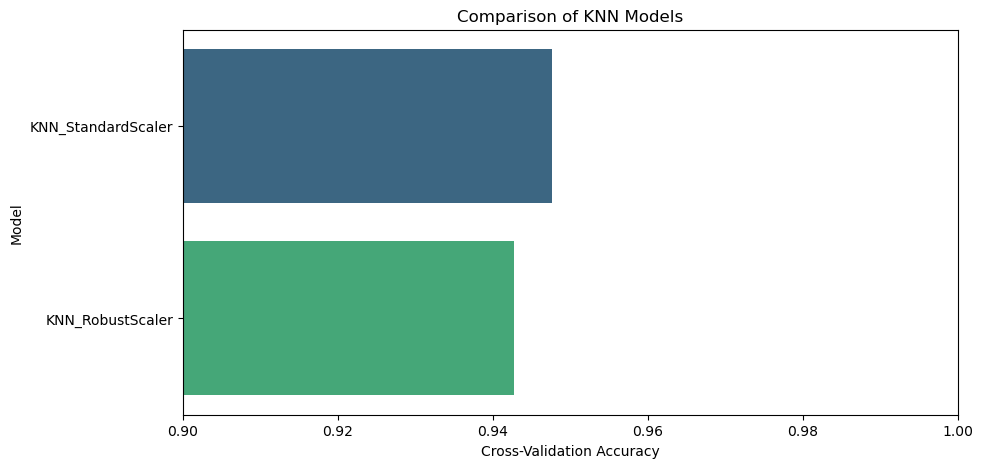


Results Summary:
             Model  Best Score                                                                     Best Params
KNN_StandardScaler    0.947581 {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}
  KNN_RobustScaler    0.942798 {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


In [31]:
# Compare results
results_df = pd.DataFrame(results).sort_values(by='Best Score', ascending=False)

# Plot comparison
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Best Score', y='Model', palette='viridis')
plt.title('Comparison of KNN Models')
plt.xlim(0.9, 1.0)
plt.xlabel('Cross-Validation Accuracy')
plt.show()

print("\n" + "="*50)
print("Results Summary:")
print("="*50)
print(results_df.to_string(index=False))

### 2.6 Evaluate best model on test set

In [32]:
# Predict on test set
y_pred = best_overall_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred)

print("="*50)
print("TEST SET EVALUATION")
print("="*50)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"\nBest Model: {results_df.iloc[0]['Model']}")
print(f"Best Params: {results_df.iloc[0]['Best Params']}")

TEST SET EVALUATION
Test Accuracy: 0.9513

Best Model: KNN_StandardScaler
Best Params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


In [33]:
# Classification Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           A       0.99      1.00      1.00       149
           B       0.89      0.92      0.90       153
           C       0.98      0.95      0.97       137
           D       0.92      0.97      0.94       156
           E       0.92      0.96      0.94       141
           F       0.91      0.92      0.92       140
           G       0.95      0.96      0.96       160
           H       0.90      0.85      0.88       144
           I       0.97      0.94      0.95       146
           J       0.95      0.96      0.95       149
           K       0.91      0.88      0.89       130
           L       0.96      0.97      0.97       155
           M       0.97      0.97      0.97       168
           N       0.96      0.91      0.94       151
           O       0.96      0.97      0.97       145
           P       0.96      0.92      0.94       173
           Q       0.99      0.98      0.98       166
    

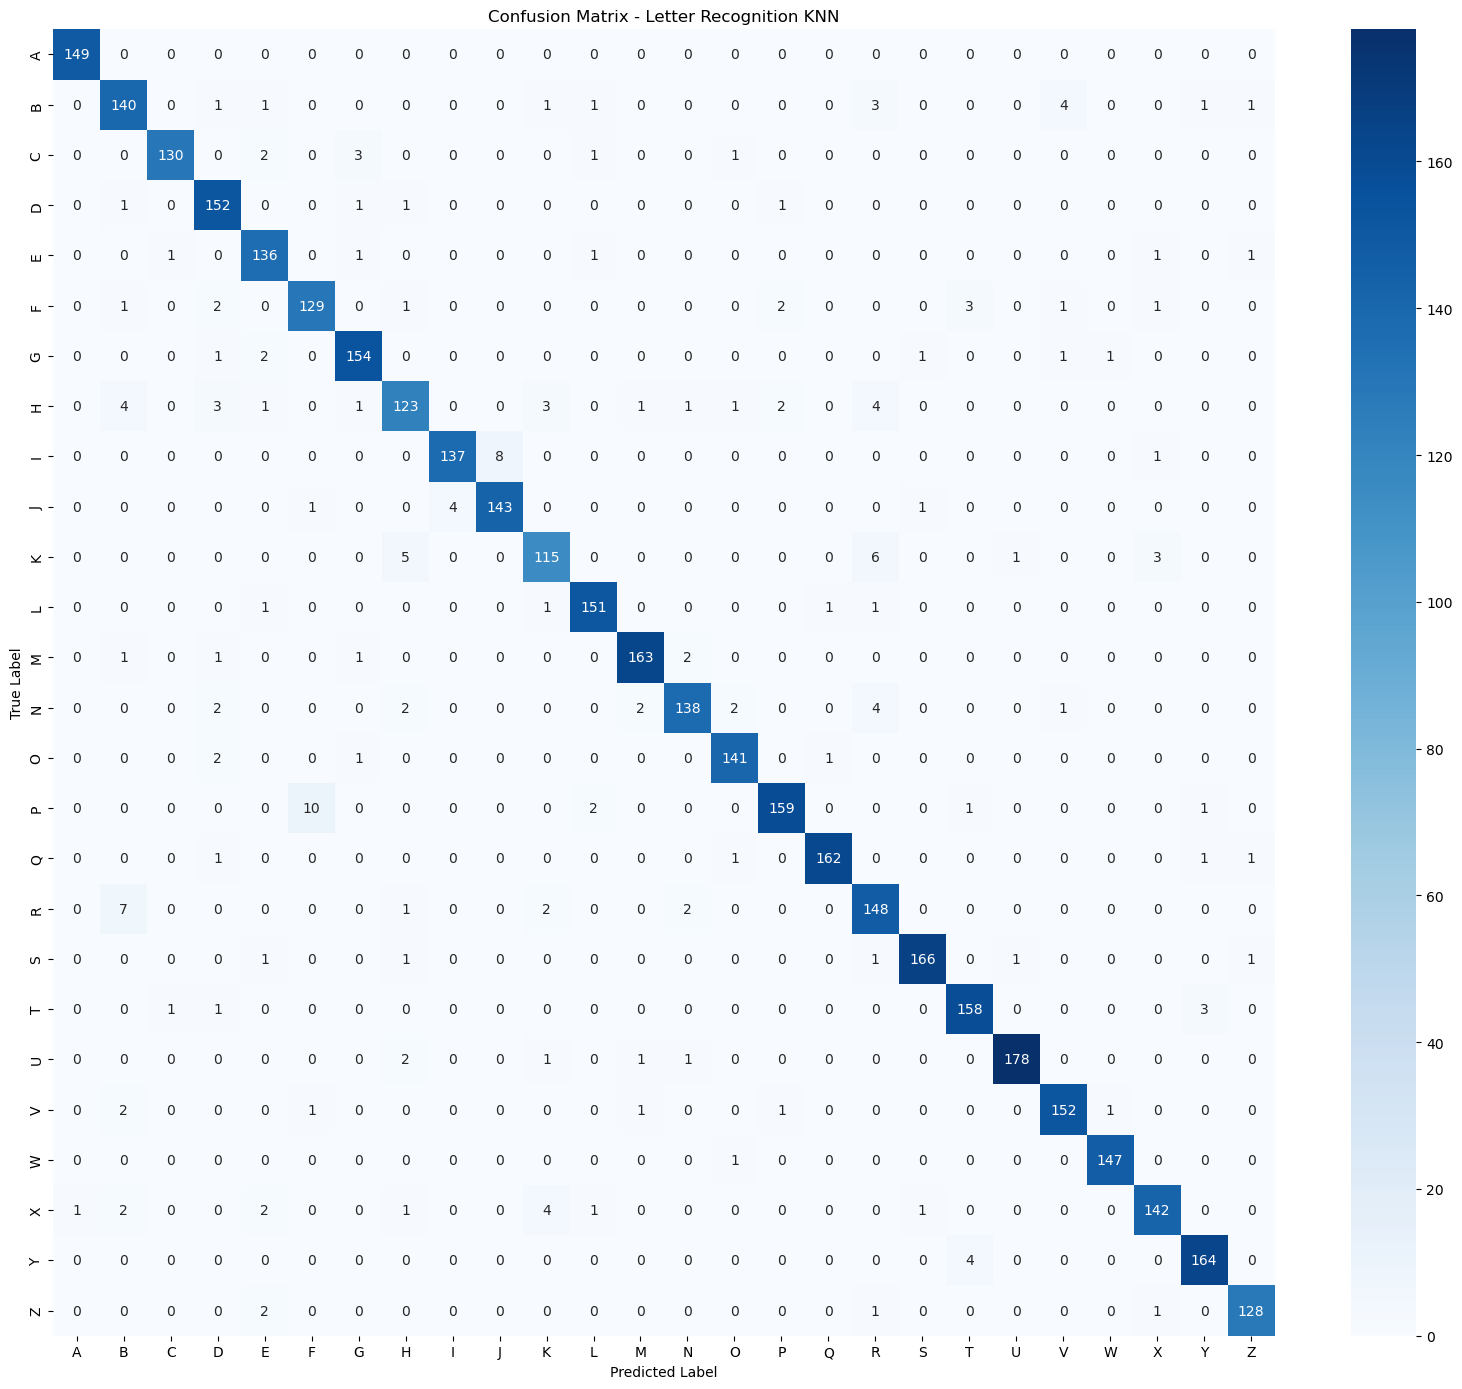

In [34]:
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Letter Recognition KNN')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### 2.7 Save the best model

In [35]:
# Save model and label encoder
model_filename = f"KNN_LetterRecognition_best_model_{formatted_current_datetime}.pkl"
encoder_filename = f"KNN_LetterRecognition_label_encoder_{formatted_current_datetime}.pkl"

# Save model
joblib.dump(best_overall_model, model_filename)
print(f"Model saved: {model_filename}")

# Save label encoder
joblib.dump(label_encoder, encoder_filename)
print(f"Label encoder saved: {encoder_filename}")

print("\n" + "="*50)
print("Model Information:")
print("="*50)
print(f"Model Type: {type(best_overall_model).__name__}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Timestamp: {formatted_current_datetime}")

Model saved: KNN_LetterRecognition_best_model_2025-11-21_21-50-53.pkl
Label encoder saved: KNN_LetterRecognition_label_encoder_2025-11-21_21-50-53.pkl

Model Information:
Model Type: Pipeline
Test Accuracy: 0.9513
Timestamp: 2025-11-21_21-50-53


---
## 3. Load Model and Predict (Demo)

### 3.1 Load saved model

In [36]:
# Example: Load the saved model for prediction
# Replace with your actual filename
# model_filename = "KNN_LetterRecognition_best_model_2025-11-21_10-30-00.pkl"
# encoder_filename = "KNN_LetterRecognition_label_encoder_2025-11-21_10-30-00.pkl"

# Load model
loaded_model = joblib.load(model_filename)
loaded_encoder = joblib.load(encoder_filename)

print(f"Model loaded successfully from: {model_filename}")
print(f"Encoder loaded successfully from: {encoder_filename}")

Model loaded successfully from: KNN_LetterRecognition_best_model_2025-11-21_21-50-53.pkl
Encoder loaded successfully from: KNN_LetterRecognition_label_encoder_2025-11-21_21-50-53.pkl


### 3.2 Make predictions with loaded model

In [37]:
# Make predictions on some test samples
sample_size = 10
X_sample = X_test.head(sample_size)
y_sample_true = y_test.head(sample_size)

# Predict
y_sample_pred_encoded = loaded_model.predict(X_sample)
y_sample_pred = loaded_encoder.inverse_transform(y_sample_pred_encoded)

# Display results
comparison_df = pd.DataFrame({
    'Index': X_sample.index,
    'True Letter': y_sample_true.values.ravel(),
    'Predicted Letter': y_sample_pred,
    'Correct': y_sample_true.values.ravel() == y_sample_pred
})

print("="*50)
print("SAMPLE PREDICTIONS")
print("="*50)
print(comparison_df.to_string(index=False))
print(f"\nAccuracy on sample: {comparison_df['Correct'].sum()}/{sample_size}")

SAMPLE PREDICTIONS
 Index True Letter Predicted Letter  Correct
 10650           T                T     True
  2041           L                L     True
  8668           A                A     True
  1114           E                E     True
 13902           Q                Q     True
 11963           E                E     True
 11072           O                O     True
  3002           Q                Q     True
 19771           G                G     True
  8115           O                O     True

Accuracy on sample: 10/10


---
## 4. Summary

**Dataset**: UCI Letter Recognition Dataset
- **Features**: 16 numeric features
- **Classes**: 26 letters (A-Z)
- **Preprocessing**:
  - Removed duplicated samples
  - Feature scaling (StandardScaler vs RobustScaler)
  
**Model**: K-Nearest Neighbors (KNN)
- **Best configuration**: Found via GridSearchCV
- **Hyperparameters tuned**:
  - n_neighbors: [3, 5, 7, 9, 11]
  - weights: ['uniform', 'distance']
  - metric: ['euclidean', 'manhattan', 'minkowski']
  

---

## The end 
